In [198]:
%reset

In [211]:
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Subset

In [212]:
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.RandomErasing(0.2),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Load and split data

In [213]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [214]:
DATA_PATH = "../train/"
dataset = datasets.ImageFolder(root=DATA_PATH)
idx_to_class = tuple([k for k, _ in dataset.class_to_idx.items()])
torch.manual_seed(42)
n_train_examples = int(len(dataset) * 0.8)
n_val_examples = len(dataset) - n_train_examples
train_indices, val_indices = random_split(range(len(dataset)), [n_train_examples, n_val_examples])
train_dataset = CustomDataset(Subset(dataset, train_indices), transform=transform_train)
val_dataset = CustomDataset(Subset(dataset, val_indices), transform=transform_val)

In [215]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

In [216]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Peek data

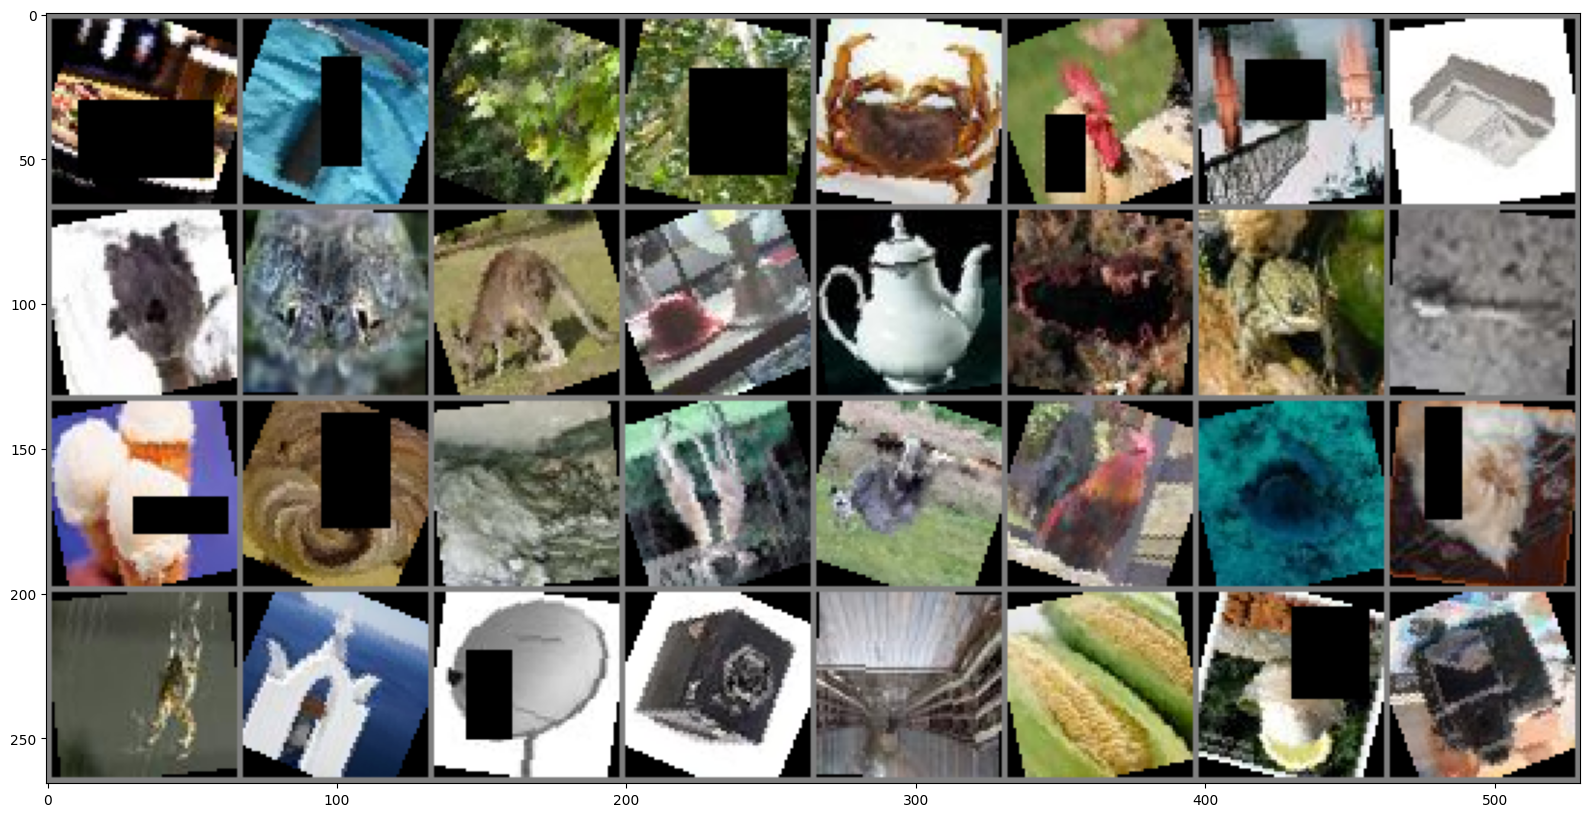

pizza hammer birch birch crab bird bridge printer swine crocodilian kangaroo acoustic pot worm frog spoon icecream nest echinoderm kangaroo kangaroo bird turtle cat spider acoustic antenna camera bridge corn icecream camera


In [217]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))

# get some random training images
images, labels = next(iter(train_loader))


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(" ".join(f"{idx_to_class[labels[j]]}" for j in range(batch_size)))

In [235]:
images[0:1].size()

torch.Size([1, 3, 64, 64])

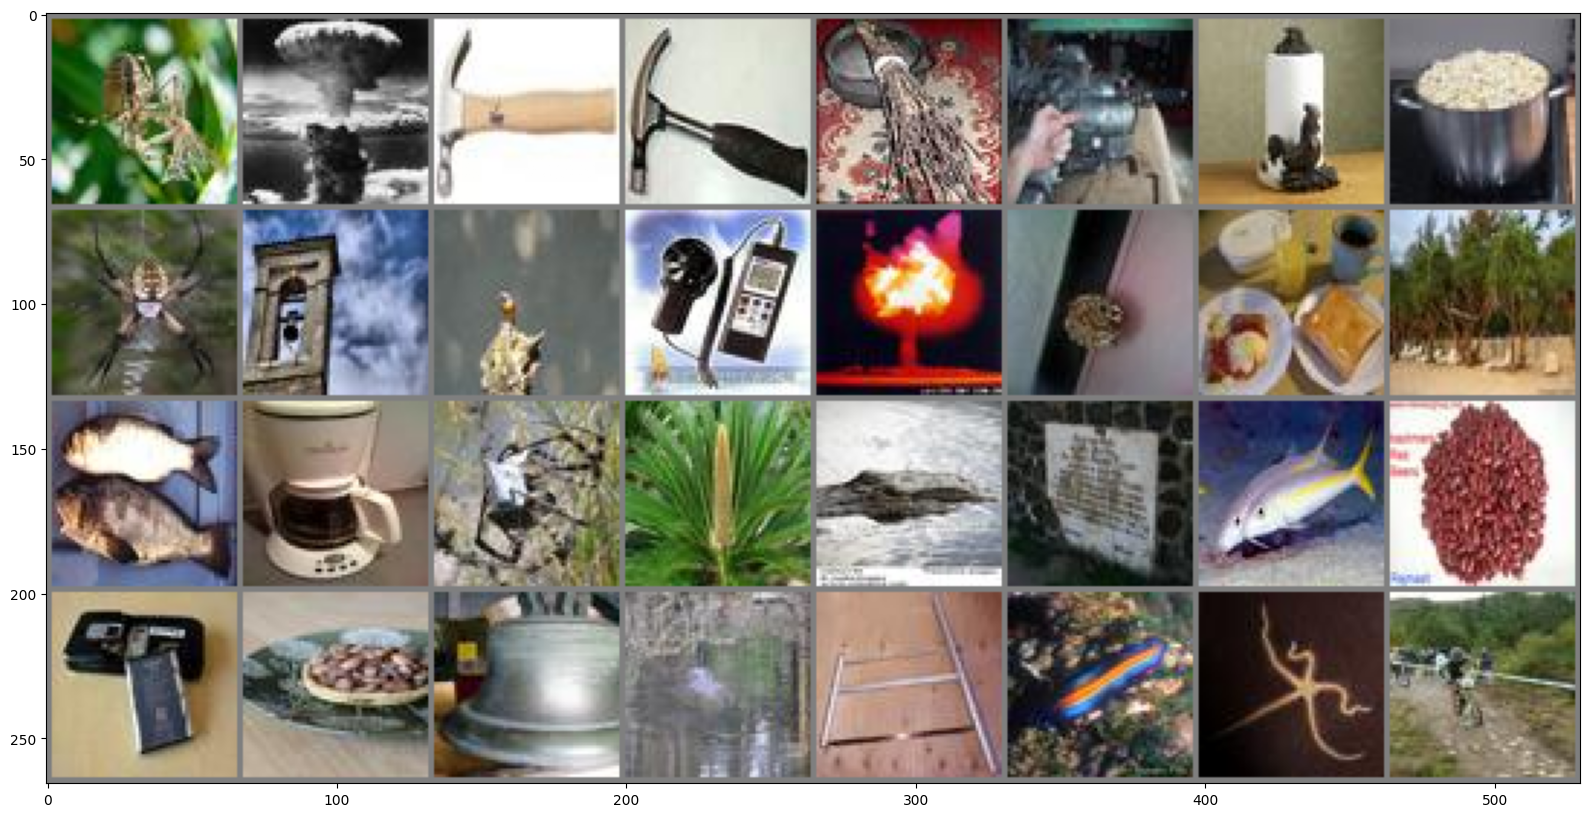

spider bomb hammer hammer pot motor towel corn spider acoustic bird gauge bomb nest bread palm fish pot spider palm crocodilian memorial fish bean battery bean acoustic crocodilian saw worm echinoderm bicycle


In [218]:
plt.figure(figsize=(20, 10))

# get some random training images
images, labels = next(iter(val_loader))


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(val_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(" ".join(f"{idx_to_class[labels[j]]}" for j in range(batch_size)))

In [257]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(128, 192, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(6912, 1028)
        self.fc2 = nn.Linear(1028, 512)
        self.fc3 = nn.Linear(512, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [258]:
model = CNN(len(dataset.classes)).to(device)

In [259]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.0001)

In [260]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
mca = MulticlassAccuracy(num_classes=50, average=None).to(device)
EPOCHS_NUMBER = 100
(
    train_losses,
    train_accuracies,
    val_losses,
    val_accuracies,
    train_f1_scores,
    val_f1_scores,
) = ([], [], [], [], [], [])
tqdm_progress = tqdm(range(EPOCHS_NUMBER))

t_batch_num, v_batch_num = len(train_loader), len(val_loader)

for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    train_batch_f1_score_sum, val_batch_f1_score_sum = 0, 0

    model.train()
    for data_patch, label in train_loader:
        data_patch, label = data_patch.to(device), label.to(device)
        optimizer.zero_grad()
        model_output = model(data_patch).squeeze()
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()

    train_batch_loss_avg = train_batch_loss_sum / t_batch_num
    train_batch_accuracy_avg = train_batch_accuracy_sum / t_batch_num

    train_losses.append(train_batch_loss_avg)
    train_accuracies.append(train_batch_accuracy_avg)

    model.eval()
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_predicts = model(val_inputs).squeeze(dim=1)
        val_loss = criterion(val_predicts, val_labels)
        val_batch_loss_sum += val_loss.item()
        val_batch_accuracy_sum += mca(torch.argmax(val_predicts, dim=1), val_labels)

    val_batch_loss_avg = val_batch_loss_sum / v_batch_num
    val_batch_accuracy_avg = val_batch_accuracy_sum / v_batch_num

    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(val_batch_loss_avg)

    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {train_batch_loss_avg},
            "Loss in eval": {val_batch_loss_avg},
        }
    )


 40%|████      | 40/100 [35:23<53:05, 53.10s/it, Epoch=40, Los in train={1.7132221393212743}, Loss in eval={1.879423096128132}]   


KeyboardInterrupt: 

In [261]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
labels_train, labels_val = torch.tensor([], device=device), torch.tensor([], device=device)
predicted_train, predicted_val = torch.tensor([], device=device), torch.tensor([], device=device)
model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predicts_train = model(inputs)
        predicted_argmax_train = torch.argmax(predicts_train, dim=1)
        labels_train = torch.cat((labels_train, labels))
        predicted_train = torch.cat((predicted_train, predicted_argmax_train))

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predicts_val = model(inputs)
        predicted_argmax_val = torch.argmax(predicts_val, dim=1)
        labels_val = torch.cat((labels_val, labels))
        predicted_val = torch.cat((predicted_val, predicted_argmax_val))


In [262]:
labels_train, predicted_train = labels_train.cpu() , predicted_train.cpu()
labels_val, predicted_val = labels_val.cpu() , predicted_val.cpu()

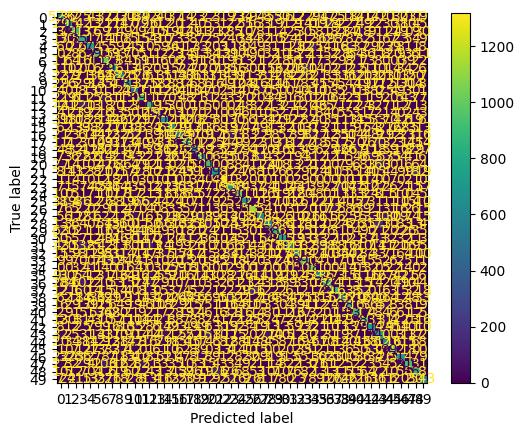

In [263]:
confusion_matrix_train = confusion_matrix(labels_train , predicted_train)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [266]:
f1_score(labels_train, predicted_train, average='micro')

0.5442989433018975

In [267]:
mca_eval = MulticlassAccuracy(num_classes=50, average=None)

In [268]:
mca_eval(predicted_train, labels_train)

tensor([0.3654, 0.4940, 0.6325, 0.5921, 0.5410, 0.6946, 0.7055, 0.5478, 0.3583,
        0.5147, 0.5508, 0.6265, 0.6300, 0.4913, 0.4917, 0.4309, 0.3247, 0.4708,
        0.4720, 0.4882, 0.6281, 0.4923, 0.9172, 0.4610, 0.6886, 0.4968, 0.7751,
        0.3978, 0.3710, 0.6091, 0.5626, 0.3723, 0.4024, 0.6967, 0.7551, 0.4000,
        0.5498, 0.6371, 0.3586, 0.6082, 0.6492, 0.6755, 0.4927, 0.5082, 0.4313,
        0.6909, 0.5042, 0.6443, 0.6066, 0.3766])

In [269]:
f1_score(labels_val, predicted_val, average='micro')

0.48457649264329944

In [270]:
mca_eval(predicted_val, labels_val)

tensor([0.2592, 0.4267, 0.5211, 0.5499, 0.4944, 0.6093, 0.6779, 0.4696, 0.2682,
        0.4761, 0.4132, 0.5228, 0.5193, 0.3627, 0.4365, 0.4049, 0.2618, 0.3978,
        0.4533, 0.4129, 0.5702, 0.4447, 0.8650, 0.3897, 0.6345, 0.3805, 0.7658,
        0.3199, 0.2891, 0.5439, 0.5493, 0.3404, 0.3399, 0.6504, 0.6594, 0.3094,
        0.5091, 0.5989, 0.3213, 0.5496, 0.6557, 0.6250, 0.3939, 0.3794, 0.4639,
        0.6497, 0.5026, 0.5953, 0.5718, 0.2933])

In [271]:
mca_eval = MulticlassAccuracy(num_classes=50, average='macro')
mca_eval(predicted_val, labels_val)

tensor(0.4820)

Text(0, 0.5, 'Loss')

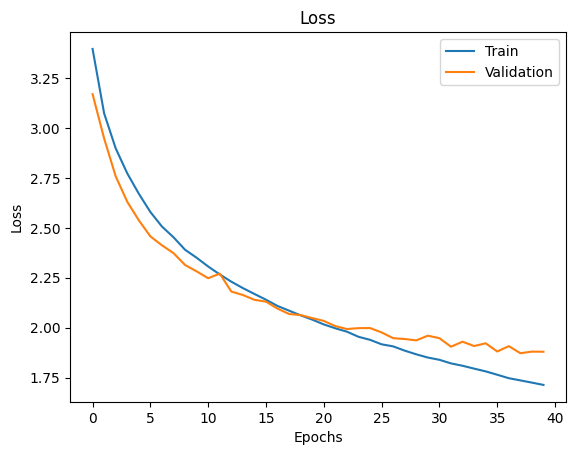

In [272]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label = "Validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")